# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [ ]:
# Check for GPU
!nvidia-smi

Sun May 26 06:57:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

 - Train for more epochs.
 - Use more (also augmented) data
 - Increase the complexity of the model.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data

import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/pizza/2426686.jpg
Image class: pizza
Image height: 341
Image width: 512


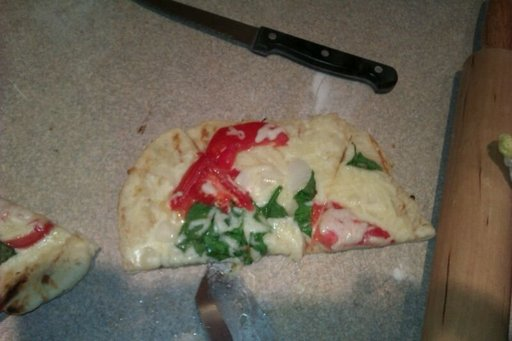

In [ ]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

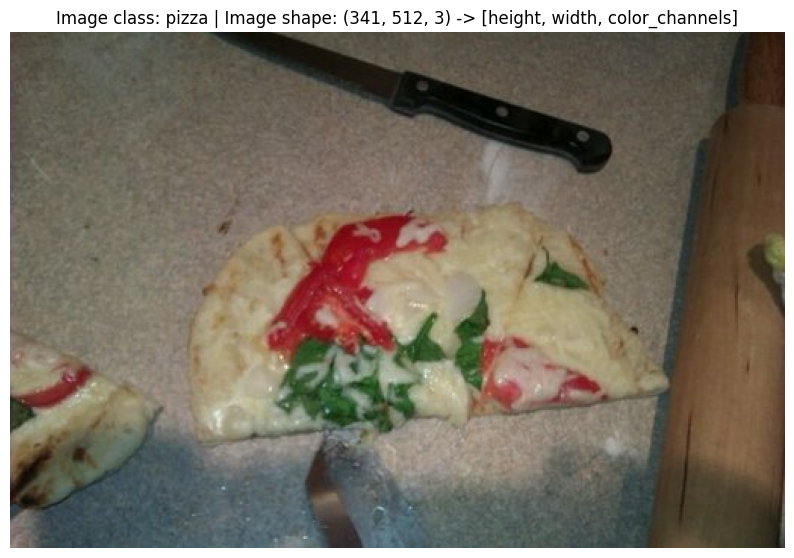

In [ ]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets

# Use the v2 version here
from torchvision.transforms import v2

In [ ]:
# Write transform for turning images into tensors
data_transform = v2.Compose([
    # Resize the images to 64x64
    v2.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    v2.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor (# this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0)
    # v2.ToTensor() is deprecated, this is the equivalent command:
    # [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

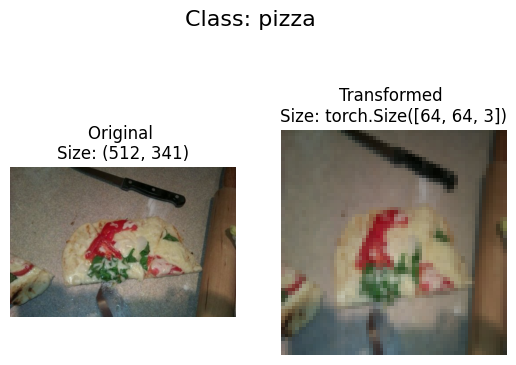

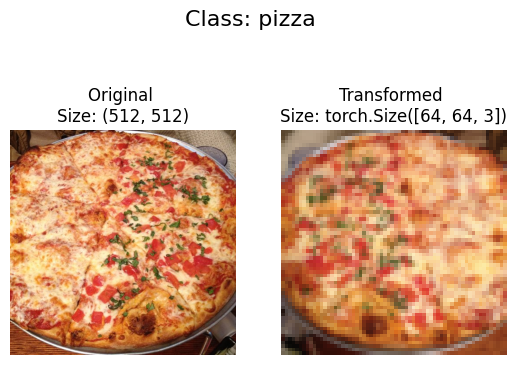

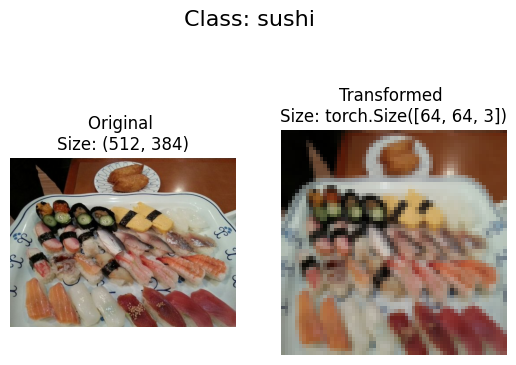

In [ ]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib - color channels last
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### Load image data using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
Image([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
        [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
        [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
        ...,
        [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
        [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
        [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

       [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
        [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
        [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
        ...,
        [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
        [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
        [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

       [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
        [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
        [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0.090

In [ ]:
# Turn train and test Datasets into DataLoaders

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8619e3c3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8619e3c5b0>)

In [ ]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [ ]:
# Train for 5 epochs
NUM_EPOCHS = 5

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG - Optional, also created above
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1415 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.2930 | test_loss: 1.1405 | test_acc: 0.1979
Total training time: 6.691 seconds


In [ ]:
# Train for 20 epochs
NUM_EPOCHS = 20

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG - Optional, also created above
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0946 | train_acc: 0.2930 | test_loss: 1.1405 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0920 | train_acc: 0.3516 | test_loss: 1.1458 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.1061 | train_acc: 0.4180 | test_loss: 1.1309 | test_acc: 0.2396
Epoch: 8 | train_loss: 1.0726 | train_acc: 0.3789 | test_loss: 1.0843 | test_acc: 0.4337
Epoch: 9 | train_loss: 1.0319 | train_acc: 0.6523 | test_loss: 1.0394 | test_acc: 0.5038
Epoch: 10 | train_loss: 0.9680 | train_acc: 0.6172 | test_loss: 0.9915 | test_acc: 0.5142
Epoch: 11 | train_loss: 0.9041 | train_acc: 0.6094 | test_loss: 0.9881 | test_acc: 0.5047
Epoch: 12 | train_l

In [ ]:
# Train for 50 epochs
NUM_EPOCHS = 50

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG - Optional, also created above
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0948 | train_acc: 0.4141 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.2930 | test_loss: 1.1403 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0921 | train_acc: 0.3555 | test_loss: 1.1461 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.1064 | train_acc: 0.4180 | test_loss: 1.1312 | test_acc: 0.2396
Epoch: 8 | train_loss: 1.0749 | train_acc: 0.3750 | test_loss: 1.0860 | test_acc: 0.4034
Epoch: 9 | train_loss: 1.0371 | train_acc: 0.6484 | test_loss: 1.0409 | test_acc: 0.5142
Epoch: 10 | train_loss: 0.9735 | train_acc: 0.6016 | test_loss: 0.9902 | test_acc: 0.5246
Epoch: 11 | train_loss: 0.9175 | train_acc: 0.5039 | test_loss: 0.9867 | test_acc: 0.4744
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Train for 20 epochs
NUM_EPOCHS = 20

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG - Optional, also created above
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10 * 2,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1048 | train_acc: 0.4219 | test_loss: 1.1072 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1214 | train_acc: 0.3047 | test_loss: 1.0975 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0916 | train_acc: 0.3984 | test_loss: 1.0999 | test_acc: 0.2188
Epoch: 4 | train_loss: 1.0944 | train_acc: 0.4336 | test_loss: 1.0798 | test_acc: 0.4943
Epoch: 5 | train_loss: 1.0861 | train_acc: 0.4141 | test_loss: 1.0682 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0477 | train_acc: 0.4414 | test_loss: 1.0821 | test_acc: 0.3532
Epoch: 7 | train_loss: 0.9755 | train_acc: 0.5898 | test_loss: 1.0562 | test_acc: 0.3220
Epoch: 8 | train_loss: 0.8805 | train_acc: 0.6172 | test_loss: 1.0226 | test_acc: 0.4138
Epoch: 9 | train_loss: 0.9187 | train_acc: 0.4570 | test_loss: 0.9138 | test_acc: 0.5975
Epoch: 10 | train_loss: 0.9250 | train_acc: 0.5195 | test_loss: 0.9981 | test_acc: 0.4536
Epoch: 11 | train_loss: 0.8995 | train_acc: 0.5938 | test_loss: 1.0446 | test_acc: 0.4640
Epoch: 12 | train_l

**Slightly better BUT:**

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.


Excellent, we now have double the training and testing images...

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Write transform for turning images into tensors
data_transform_2 = v2.Compose([
    # Resize the images to 64x64
    v2.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    v2.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor (# this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0)
    # v2.ToTensor() is deprecated, this is the equivalent command:
    # [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Create datasets
# Use ImageFolder to create dataset(s)
train_data_2 = datasets.ImageFolder(root=train_data_20_percent_path, # target folder of images
                                  transform=data_transform_2, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data_2 = datasets.ImageFolder(root=test_data_20_percent_path,
                                 transform=data_transform_2)

print(f"Train data:\n{train_data_20_percent_path}\nTest data:\n{test_data_20_percent_path}")

# Create dataloaders
# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_2 = DataLoader(dataset=train_data_2,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader_2 = DataLoader(dataset=test_data_2,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

Train data:
data/pizza_steak_sushi_20_percent/train
Test data:
data/pizza_steak_sushi_20_percent/test


In [ ]:
# Train a model with increased amount of data, for 20 epochs and double the hidden units
NUM_EPOCHS = 20
HIDDEN_UNITS = 10 * 2

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG - Optional, also created above
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=HIDDEN_UNITS,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1044 | train_acc: 0.3375 | test_loss: 1.1010 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0809 | train_acc: 0.3625 | test_loss: 1.0663 | test_acc: 0.4335
Epoch: 3 | train_loss: 1.0015 | train_acc: 0.4833 | test_loss: 0.9507 | test_acc: 0.5233
Epoch: 4 | train_loss: 0.9124 | train_acc: 0.5417 | test_loss: 0.9405 | test_acc: 0.5500
Epoch: 5 | train_loss: 0.8825 | train_acc: 0.5958 | test_loss: 0.9098 | test_acc: 0.4960
Epoch: 6 | train_loss: 0.8326 | train_acc: 0.6271 | test_loss: 0.9984 | test_acc: 0.4966
Epoch: 7 | train_loss: 0.9058 | train_acc: 0.5875 | test_loss: 0.9000 | test_acc: 0.5119
Epoch: 8 | train_loss: 0.8045 | train_acc: 0.6583 | test_loss: 0.8797 | test_acc: 0.6131
Epoch: 9 | train_loss: 0.8211 | train_acc: 0.6625 | test_loss: 0.9151 | test_acc: 0.5210
Epoch: 10 | train_loss: 0.8734 | train_acc: 0.5687 | test_loss: 0.9029 | test_acc: 0.5642
Epoch: 11 | train_loss: 0.8164 | train_acc: 0.6125 | test_loss: 0.8655 | test_acc: 0.6062
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

Again, it is slightly better than before, the additional data seem to have helped. But it is STILL overfitting. We could improve it further by adding yet more data, changing the learning rate, adding more convolutional layers, hidden_units, or even use transfer learning etc.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "sushi-roll.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # Use the "raw" file link
        request = requests.get("https://media-cdn.tripadvisor.com/media/photo-s/0f/17/00/aa/sushi-roll.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[ 49,  49,  50,  ...,  84,  85,  88],
         [ 56,  54,  54,  ...,  86,  84,  84],
         [ 49,  48,  48,  ...,  86,  86,  84],
         ...,
         [ 47,  48,  47,  ..., 220, 221, 222],
         [ 47,  46,  45,  ..., 221, 222, 222],
         [ 43,  41,  42,  ..., 222, 222, 222]],

        [[ 25,  25,  26,  ...,  71,  72,  75],
         [ 32,  30,  30,  ...,  73,  71,  71],
         [ 28,  27,  27,  ...,  73,  71,  69],
         ...,
         [ 28,  29,  28,  ..., 207, 208, 209],
         [ 28,  27,  26,  ..., 208, 209, 209],
         [ 27,  25,  23,  ..., 209, 209, 209]],

        [[ 23,  23,  24,  ...,  89,  90,  93],
         [ 30,  28,  28,  ...,  91,  91,  89],
         [ 27,  26,  26,  ...,  93,  94,  90],
         ...,
         [ 30,  31,  30,  ..., 217, 218, 219],
         [ 30,  29,  28,  ..., 218, 219, 219],
         [ 28,  26,  25,  ..., 219, 219, 219]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 413, 550])

Custom image dtype

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1922, 0.1922, 0.1961,  ..., 0.3294, 0.3333, 0.3451],
         [0.2196, 0.2118, 0.2118,  ..., 0.3373, 0.3294, 0.3294],
         [0.1922, 0.1882, 0.1882,  ..., 0.3373, 0.3373, 0.3294],
         ...,
         [0.1843, 0.1882, 0.1843,  ..., 0.8627, 0.8667, 0.8706],
         [0.1843, 0.1804, 0.1765,  ..., 0.8667, 0.8706, 0.8706],
         [0.1686, 0.1608, 0.1647,  ..., 0.8706, 0.8706, 0.8706]],

        [[0.0980, 0.0980, 0.1020,  ..., 0.2784, 0.2824, 0.2941],
         [0.1255, 0.1176, 0.1176,  ..., 0.2863, 0.2784, 0.2784],
         [0.1098, 0.1059, 0.1059,  ..., 0.2863, 0.2784, 0.2706],
         ...,
         [0.1098, 0.1137, 0.1098,  ..., 0.8118, 0.8157, 0.8196],
         [0.1098, 0.1059, 0.1020,  ..., 0.8157, 0.8196, 0.8196],
         [0.1059, 0.0980, 0.0902,  ..., 0.8196, 0.8196, 0.8196]],

        [[0.0902, 0.0902, 0.0941,  ..., 0.3490, 0.3529, 0.3647],
         [0.1176, 0.1098, 0.1098,  ..., 0.3569, 0.3569, 0.3490],
         [0.1059, 0.1020, 0.1020,  ..

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = v2.Compose([
    v2.Resize((64, 64))
    # Already converted manually to tensor AND correct tensor type.
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True)
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 413, 550])
New shape: torch.Size([3, 64, 64])


In [ ]:
model_0.eval()
with torch.inference_mode():
    # Add an extra dimension to image of batch_size = 1
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.1563, -3.2548,  1.7981]], device='cuda:0')
Prediction probabilities: tensor([[0.1234, 0.0056, 0.8711]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')


In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'sushi'

**It's correct, and with a high probability too!**

Adding it all together into a function, and plotting the image as well:

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names:str, # --> Simpler code, instead of this: List[str] = None
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

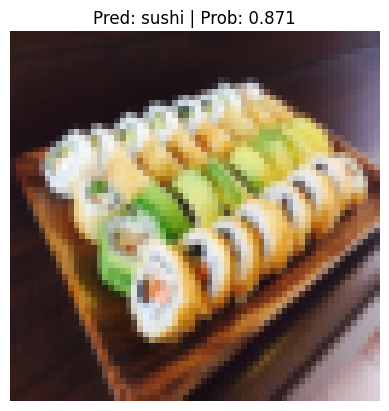

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)